Step 1: Pick the best Sentiment Analysis Model

In [1]:
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
import pandas as pd
import chardet
import nltk
nltk.download('vader_lexicon')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import KFold
from transformers import BertTokenizer, BertModel
from transformers import get_linear_schedule_with_warmup
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import AdamW
import sys 
import os
import matplotlib.pyplot as plt
# sys.path.append(os.path.abspath("/Users/13793/Desktop/aas/stock"))


# Add the project root directory to the Python path
import subprocess
result = subprocess.check_output(["git", "rev-parse", "--show-toplevel"], universal_newlines=True)
git_root = result.strip()
sys.path.append(git_root)

from src import processer as processer


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\joesc\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\joesc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
c:\Users\joesc\anaconda3\envs\stock_pred\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Clean the raw data with 'processer'

In [2]:
# Trained the model by a data set with text and sentiment
data = pd.read_csv('../data/twitter.csv', encoding='ISO-8859-1')
data = processer.Preprocess_Tweets(data)
data


c:\Users\joesc\anaconda3\envs\stock_pred\Lib\site-packages\pandas\core\strings\object_array.py:172: FutureWarning: Possible nested set at position 1
  pat = re.compile(pat, flags=flags)


,Text,Sentiment
0,kickers watchlist xide tit soq pnk cpw bpz aj ...,1
1,aap movie 55 percent return fea geed indicator...,1
2,id afraid short amzn looking like near monopol...,1
3,mnta 12.00,1
4,oi 21.37,1
...,...,...
5786,industry body cii said likely suffer net reven...,-1
5787,prices slip below rs 46000 book profits amid l...,-1
5788,workers bajaj auto agreed 10 percent wage cut ...,1
5789,live sensex days high up 600 points tests 92...,1


Three Models: 

1. Base Line vader Sentiment analysis model

2. Naive Bayesian model

3. BERT NN model

In [3]:
model = SentimentIntensityAnalyzer()
#baseline
data['V_score'] = data['Text'].apply(lambda score: model.polarity_scores(score)['compound'])
data['V_prediction'] = data['V_score'].apply(lambda score: 1 if score>=0 else -1)
print('Vader Accuracy:', round((len(data[data['Sentiment']==data['V_prediction']])/len(data)) *100, 2), '%', '\n')
Stats = []
Stats.append(round((len(data[data['Sentiment']==data['V_prediction']])/len(data)) *100, 2))

Vader Accuracy: 66.14 % 



In [4]:
#Naive Bayesian Train/Test
train_pct = .8
np.random.seed(100)
idx = np.random.permutation(len(data))

X_train = data['Text'].values[idx[:int(train_pct*len(data))]]
y_train = data['Sentiment'].values[idx[:int(train_pct*len(data))]]
y_train[y_train==-1] = 0
X_test = data['Text'].values[idx[int(train_pct*len(data)):]]
y_test = data['Sentiment'].values[idx[int(train_pct*len(data)):]]
y_test[y_test==-1] = 0

# Calculate TF-IDF for Naive Bayes classification
tf_idf = TfidfVectorizer(ngram_range=(1, 3),
                         binary=True,
                         smooth_idf=False)
X_train_tfidf = tf_idf.fit_transform(X_train)
X_test_tfidf = tf_idf.transform(X_test)


# Define AreaUnderCurve function to determine accuracy of model
def auc_CV(model):
    kf = StratifiedKFold(5, shuffle=True, random_state=1)

    auc = cross_val_score(model, X_train_tfidf, y_train, scoring="roc_auc", cv=kf)

    return auc.mean()

# Find best performing model
alphas = np.arange(0.4,1.5,0.1)
models = [MultinomialNB(alpha=i) for i in alphas]
accs = []
for model in models:
    accs.append(auc_CV(model))
accs = np.array(accs)
best_alpha = round(alphas[accs.argmax()], 1)

# Print best alpha value and accuracy
print('Best alpha: ', best_alpha, '  |  Best Score: ', round(accs.max()*100, 2))

# Retrain best performing model
best_model = MultinomialNB(alpha=best_alpha)
best_model.fit(X_train_tfidf, y_train)
probs = best_model.predict_proba(X_test_tfidf)

# Print accuracy of best performing model on tweet sentiment analysis 
print('Naive-Bayes Accuracy:', round(len(np.where(y_test == probs.argmax(axis=1))[0])/len(probs) * 100, 2), '%')
Stats.append(round(len(np.where(y_test == probs.argmax(axis=1))[0])/len(probs) * 100, 2))

Best alpha:  0.6   |  Best Score:  84.35
Naive-Bayes Accuracy: 71.7 %


In [5]:
#K-Fold
kfold = KFold(n_splits=5,
                 shuffle=True,
                 random_state=132)
mses = np.zeros((1, 5))
i=0
for train_index, test_index in kfold.split(data):
    X_train = data.loc[train_index]['Text']
    y_train = data.loc[train_index]['Sentiment']
    y_train[y_train==-1] = 0
    X_test = data.loc[test_index]['Text']
    y_test = data.loc[test_index]['Sentiment']
    y_test[y_test==-1] = 0
    
    # Calculate TF-IDF for Naive Bayes classification
    tf_idf = TfidfVectorizer(ngram_range=(1, 3),
                         binary=True,
                         smooth_idf=False)
    X_train_tfidf = tf_idf.fit_transform(X_train)
    X_test_tfidf = tf_idf.transform(X_test)
 
    #Use the best model
    best_model = MultinomialNB(alpha=0.6)
    best_model.fit(X_train_tfidf, y_train)
    probs = best_model.predict_proba(X_test_tfidf)
   
    mses[0,i] = round(len(np.where(y_test == probs.argmax(axis=1))[0])/len(probs) * 100, 2)
    i=i+1
print('Naive-Bayes Accuracy (K-Fold):', mses.mean(), '%')
Stats.append(mses.mean())

Naive-Bayes Accuracy (K-Fold): 71.804 %


Bert Sentiment Analysis

In [6]:
#Train Test Split
train_pct = .8
np.random.seed(10)
idx = np.random.permutation(len(data))

X_train = data['Text'].values[idx[:int(train_pct*len(data))]]
y_train = data['Sentiment'].values[idx[:int(train_pct*len(data))]]
y_train[y_train==-1] = 0
X_test = data['Text'].values[idx[int(train_pct*len(data)):]]
y_test = data['Sentiment'].values[idx[int(train_pct*len(data)):]]
y_test[y_test==-1] = 0

In [7]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case = True)

c:\Users\joesc\anaconda3\envs\stock_pred\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [8]:
#BERT processing function
def prep(data):
    input_ids = []
    attention_masks = []
    
    #encode data
    for i in data:
        encoding = tokenizer.encode_plus(
                text=i, 
                add_special_tokens=True, 
                padding='max_length', 
                max_length = MAX_LEN, 
                truncation=True, 
                return_tensors="pt", 
                return_attention_mask=True )

        # add the encodings to the list
        input_ids.append(encoding.get('input_ids'))
        attention_masks.append(encoding.get('attention_mask'))
    
    # return the lists as tensors
    input_ids = torch.concat(input_ids)
    attention_masks = torch.concat(attention_masks)
    
    return input_ids, attention_masks

In [9]:
#Setting up for BERT
encoded = [tokenizer.encode(i, add_special_tokens=True) for i in data['Text'].values]
MAX_LEN = max([len(i) for i in encoded])
print('Max length: ', MAX_LEN)
X_train_inputs, X_train_masks = prep(X_train)
X_test_inputs, X_test_masks = prep(X_test)
y_train_labels = torch.tensor(y_train)
y_test_labels = torch.tensor(y_test)

batch_size = 16

train_data = TensorDataset(X_train_inputs, X_train_masks, y_train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

test_data = TensorDataset(X_test_inputs, X_test_masks, y_test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

Max length:  48


In [10]:
# Define the Bert NLP Classifier
class BertClassifier(nn.Module):
    def __init__(self, freeze=False):
        super(BertClassifier, self).__init__()
        input_layer = 768
        hidden_layer = 40
        output_layer = 2

        # Use the pretrained Bert model for first section of NN
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Define a final layer to attach to the Bert model for custom classification
        self.classifier = nn.Sequential(
            nn.Linear(input_layer, hidden_layer), 
            nn.ReLU(), 
            nn.Linear(hidden_layer, output_layer))

        # Freeze the model from updating
        if freeze:
            for i in self.bert.parameters():
                i.requires_grad = False
        
    # Return classification from Bert model 
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask)
        layer = outputs[0][:, 0, :]
        logits = self.classifier(layer)

        return logits

In [11]:
# Train the Model
torch.manual_seed(1)
torch.cuda.manual_seed_all(1)
np.random.seed(1)

# Check if GPU is available and assign device 
if torch.cuda.is_available():       
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [12]:
model = BertClassifier(freeze=False)
model.to(device)

# Define model hyperparameters
epochs = 4
steps = len(train_dataloader) * epochs
lr = 8e-5
eps = 1e-8
optimizer = AdamW(model.parameters(), lr=lr, eps=eps)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=steps)
loss_function = nn.CrossEntropyLoss()

for e in range(epochs):
    # Assign model to train
    model.train()

    # Intialize loss to zero
    train_loss = 0
    
    for batch in train_dataloader:
        batch_inputs, batch_masks, batch_labels = batch
        batch_inputs = batch_inputs.to(device)
        batch_masks = batch_masks.to(device)
        batch_labels = batch_labels.to(device)

        # Reset the model gradient
        model.zero_grad()

        # Get classification of encoded values
        logits = model(batch_inputs, batch_masks)
        
        # Calculate loss based on predictions and known values
        loss = loss_function(logits, batch_labels)
        train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    # Calculate the average loss over batch
    train_loss /= len(train_dataloader)
    
    # Assign the model to evaluate    
    model.eval()

    # Initialize losses
    test_loss = 0
    test_acc = 0

    for batch in test_dataloader:
        batch_inputs, batch_masks, batch_labels = batch
        batch_inputs = batch_inputs.to(device)
        batch_masks = batch_masks.to(device)
        batch_labels = batch_labels.to(device)
        with torch.no_grad():
            logits = model(batch_inputs, batch_masks)
        loss = loss_function(logits, batch_labels)
        test_loss += loss.item()

        # Convert predictions to 0 and 1 Notice:Here 0/1 is enough, detailed sentiment score could derive at overfitting
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate accuracy of model on test data; NOTICE: this accuracy function has to align with previous models
        accuracy = (preds == batch_labels).cpu().numpy().mean() * 100
        test_acc += accuracy

    # Calculate average loss and accuracy per each batch
    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)

    print('Epoch: %d  |  Train Loss: %1.5f  |  Test Loss: %1.5f  |  Test Accuracy: %1.2f'%(e+1, train_loss, test_loss, test_acc))
    
torch.save(model.state_dict(), 'stock_sentiment_model.pt')

c:\Users\joesc\anaconda3\envs\stock_pred\Lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\joesc\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [ ]:
#Check BERT accuracy
model = BertClassifier(freeze=False)
model.load_state_dict(torch.load('stock_sentiment_model.pt'))
model.to(device)
model.eval()

predictions = []

for batch in test_dataloader:
    batch_inputs, batch_masks, batch_labels = batch

    batch_inputs = batch_inputs.to(device)
    batch_masks = batch_masks.to(device)
    batch_labels = batch_labels.to(device)

    with torch.no_grad():
        logits = model(batch_inputs, batch_masks)


    preds = torch.argmax(logits, dim=1).flatten()
    predictions.append(preds)
        
predictions = torch.cat(predictions).cpu().numpy()

#Due to this phenomenon, later we designed two scores 1/2 for positive sentiment
negatives = np.where(y_test==0)[0]
TNs = np.where( (y_test==0) & (y_test==predictions) )[0]
print('Accuracy for negative sentiment: ',(len(TNs)/len(negatives))*100,'%')
Stats.append((len(TNs)/len(negatives))*100)
positives = np.where(y_test==1)[0]
TPs = np.where( (y_test==1) & (y_test==predictions) )[0]
print('Accuracy for positive sentiment: ',(len(TPs)/len(positives))*100,'%')
Stats.append((len(TPs)/len(positives))*100)
TT = np.where( (y_test==predictions) )[0]
print('Accuracy for total sentiment: ',(len(TT)/len(y_test))*100,'%')
Stats.append((len(TT)/len(y_test))*100)

Accuracy for negative sentiment:  76.22377622377621 %
Accuracy for positive sentiment:  86.43835616438355 %
Accuracy for total sentiment:  82.65746333045729 %


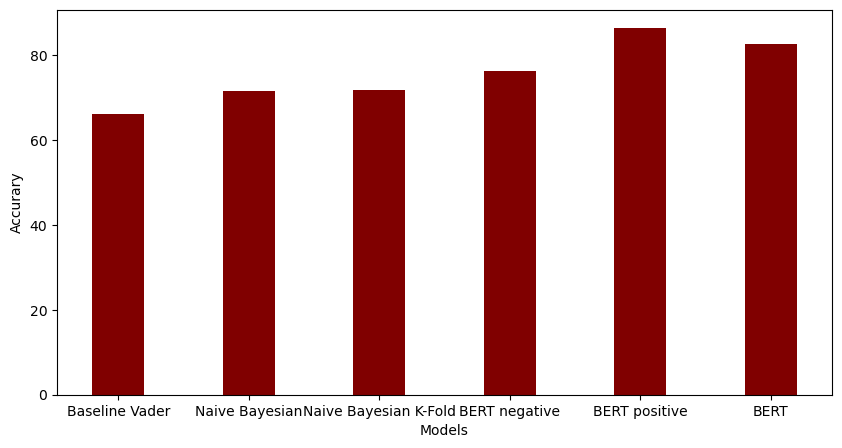

In [ ]:
fig = plt.figure(figsize = (10, 5))
ModelType = ['Baseline Vader', 'Naive Bayesian','Naive Bayesian K-Fold','BERT negative', 'BERT positive', 'BERT']
# creating the bar plot
plt.bar(ModelType, Stats, color ='maroon', 
        width = 0.4)

plt.xlabel("Models")
plt.ylabel("Accurary")
plt.show()

BERT model perform the best, we choose BERT for the next step